In this notebook, we use the clean_data.csv dataset to build a model to predict LC in the instance that LC is not 0 (continuous)
- RUN ORDER = 2/5

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

- Parse the clean data to only include rows where LC is not 0
- We want to test the data only on instances where LC is not equal to 0

In [4]:
df = pd.read_csv("clean_data.csv")

In [5]:
a = len(df)

In [6]:
df = df[df['LC'] != 0]

In [7]:
# build a random forest

- We drop HALC and made_claim (CS) because we need LC to predict HALC, then use LC and HALC - together with the rest of the features - to predict if a claim has been made

In [9]:
df['LC'].describe()

count      4151.000000
mean        629.839300
std        2448.338409
min           4.006923
25%          73.970000
50%         188.020000
75%         608.002083
max      118142.590000
Name: LC, dtype: float64

In [10]:
# df['LC'] = np.log1p(df['LC'])
# from scipy.stats.mstats import winsorize

# df['LC'] = winsorize(df['LC'], limits=[0.01, 0.01])


In [11]:
df = df.drop(columns=['HALC', 'made_claim'])

In [12]:
df.head()

,is_channel_broker,total_pol_year,total_pol_held,max_policies,max_products,canceled_policies,is_halfyearly,net_premium,risk_type,is_urban,...,next_renewal_month,next_renewal_year,license_issue_date_day,license_issue_date_month,license_issue_date_year,is_youngin,is_adult,is_middleaged,is_old,LC
18,0,3,2,2,1,0,1,341.78,3,0,...,5,2019,27,11,2008,0,1,0,0,25.975
24,1,4,2,2,2,0,0,300.01,3,0,...,4,2019,25,1,2000,0,0,1,0,752.300
29,1,2,2,2,1,0,1,191.00,2,0,...,1,2019,10,10,1994,0,0,1,0,2227.000
37,0,4,2,2,1,0,0,252.45,3,0,...,2,2019,15,10,1987,0,0,1,0,33.555
40,1,4,6,6,1,0,1,331.29,3,0,...,7,2019,17,6,2002,0,1,0,0,334.140


In [13]:
b = len(df)

In [14]:
# remove outliers in df to better represent the data
Q1 = df['LC'].quantile(0.25)
Q3 = df['LC'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['LC'] >= lower_bound) & (df['LC'] <= upper_bound)]


In [15]:
c = len(df)

In [16]:
# a = length of clean_data.csv
# b = length of df where LC does not equal 0
# c = length of df (where LC does not equal 0) after removing outliers

In [17]:
a

37451

In [18]:
b

4151

In [19]:
c

3828

In [20]:
(b - c) / a

0.008624602814344077

In [21]:
X = df.drop(columns=['LC'])
y = df['LC']

In [22]:
X

,is_channel_broker,total_pol_year,total_pol_held,max_policies,max_products,canceled_policies,is_halfyearly,net_premium,risk_type,is_urban,...,next_renewal_day,next_renewal_month,next_renewal_year,license_issue_date_day,license_issue_date_month,license_issue_date_year,is_youngin,is_adult,is_middleaged,is_old
18,0,3,2,2,1,0,1,341.78,3,0,...,22,5,2019,27,11,2008,0,1,0,0
24,1,4,2,2,2,0,0,300.01,3,0,...,30,4,2019,25,1,2000,0,0,1,0
37,0,4,2,2,1,0,0,252.45,3,0,...,27,2,2019,15,10,1987,0,0,1,0
40,1,4,6,6,1,0,1,331.29,3,0,...,18,7,2019,17,6,2002,0,1,0,0
42,1,2,2,2,1,2,1,309.16,3,0,...,6,6,2018,16,3,2010,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37377,0,1,1,1,1,0,0,209.08,3,0,...,9,6,2019,6,4,1976,0,0,0,1
37392,1,3,2,2,1,0,0,119.52,3,0,...,26,1,2017,10,9,1984,0,0,1,0
37417,1,6,1,2,1,0,1,271.43,3,1,...,23,7,2019,30,9,1994,0,0,1,0
37425,1,2,2,3,1,0,1,315.91,3,0,...,2,12,2018,9,12,2005,0,1,0,0


In [23]:
y

18        25.975
24       752.300
37        33.555
40       334.140
42       242.870
          ...   
37377     48.500
37392     57.275
37417    939.385
37425    347.725
37426    135.870
Name: LC, Length: 3828, dtype: float64

<Axes: >

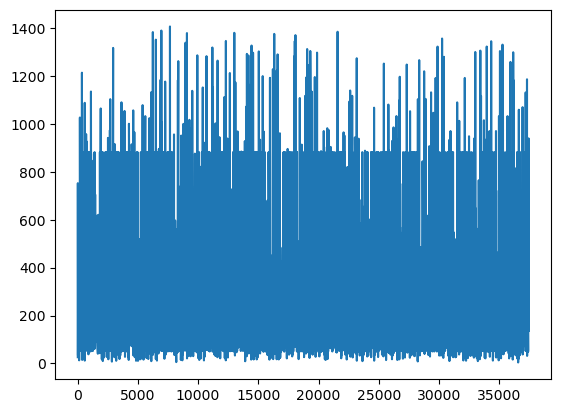

In [24]:
y.plot()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [26]:
y_train

31025     51.950
33197     64.320
8433      51.950
7144     304.882
36800    566.080
          ...   
11439     80.580
12802    544.710
8728      60.150
34346     51.950
31381     63.340
Name: LC, Length: 3062, dtype: float64

- We fit a random forest regressor to the data where LC is not equal to 0
  - We use a random forest regressor because of it's robustness and it's ability to handle outliers
  - Interpretability is also not a goal as we just want to focus on predictive power.
  - Also, RF does well with many features
  - RF does well with unbalanced data
- This model will predict a continuous value for LC if LC is not equal to 0

In [28]:
another_rf = RandomForestRegressor(n_estimators=100, random_state=42)
another_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [29]:
y_pred = another_rf.predict(X_test)

- With our predictions, we get an RMSE of 324.719
- Remember, we are only building a random forest by training data where LC is not equal to 0

In [31]:
mean_squared_error(y_test, y_pred, squared=False)

324.7192024734322

In [32]:
import joblib
joblib.dump(another_rf, 'predict_LC.pkl')

['predict_LC.pkl']

In [33]:
X_test

,is_channel_broker,total_pol_year,total_pol_held,max_policies,max_products,canceled_policies,is_halfyearly,net_premium,risk_type,is_urban,...,next_renewal_day,next_renewal_month,next_renewal_year,license_issue_date_day,license_issue_date_month,license_issue_date_year,is_youngin,is_adult,is_middleaged,is_old
28782,1,1,1,1,1,0,0,250.33,3,0,...,16,7,2019,1,5,1972,0,0,0,1
36243,1,11,1,1,1,0,1,716.08,2,0,...,15,7,2019,15,2,2006,0,1,0,0
19535,0,7,5,5,1,0,1,335.01,3,0,...,14,9,2019,5,3,2001,0,1,0,0
30073,0,1,1,1,1,0,0,345.92,3,0,...,29,8,2019,21,1,2014,0,1,0,0
16785,0,3,1,1,1,0,0,262.58,3,1,...,2,7,2019,2,5,1978,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10887,0,2,2,2,1,1,0,344.26,3,0,...,2,5,2018,21,11,1979,0,0,1,0
23823,0,10,1,5,1,0,1,257.39,2,0,...,30,1,2019,15,5,1987,0,0,1,0
4487,0,17,2,6,2,1,1,592.94,3,0,...,24,12,2016,14,12,1977,0,0,1,0
8220,0,12,2,3,1,0,0,245.52,3,0,...,12,2,2019,1,11,1994,0,0,1,0


In [34]:
df.columns

Index(['is_channel_broker', 'total_pol_year', 'total_pol_held', 'max_policies',
       'max_products', 'canceled_policies', 'is_halfyearly', 'net_premium',
       'risk_type', 'is_urban', 'is_multidriver', 'regis_year', 'horsepower',
       'cylinder_cap', 'market_value', 'door_count', 'is_petrol',
       'vehicle_weight', 'pol_start_day', 'pol_start_month', 'pol_start_year',
       'last_renewal_day', 'last_renewal_month', 'last_renewal_year',
       'next_renewal_day', 'next_renewal_month', 'next_renewal_year',
       'license_issue_date_day', 'license_issue_date_month',
       'license_issue_date_year', 'is_youngin', 'is_adult', 'is_middleaged',
       'is_old', 'LC'],
      dtype='object')

In [35]:
np.mean(y_test)

321.5321566055789

In [36]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(r2)


0.013889968954350018
